In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

import os
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime

# Verify GPU is detected

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Force TF to only allocate memory as needed on the GPU, otherwise TF attempts to allocate all the memory incase it needs it.
TF using all the memory leads to the "Failed to get convolution algorithm. This is probably because cuDNN failed to initialize," error.
Note that if RTX Voice (or other GPU memory heavy application) isn't running then this isn't needed.

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7168)])
    except RuntimeError as e:
        print(e)

# Training parameters

In [5]:
BATCH_SIZE = 8
EPOCHS = 500

# Image size in pixels.
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Number of images in the training set.
N_TRAIN = 481

# Number of image classes / categories.
CLASS_COUNT = 9

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

# Extra note added to the details file.
EXTRA_NOTES = "Transfer Learning, Cross"

# Load Data

In [6]:
# Directories of data, each catergory / class of data is in a seperate folder.
# TRAINING_DIR = "training_data/training"
# VALIDATION_DIR = "training_data/validation"
TRAINING_DIR = "reduced_training_data/training"
VALIDATION_DIR = "reduced_training_data/validation"

In [7]:
# Rescale here refers to scaling the pixel values from a range of [0, 255] to a range of [0, 1].
train_image_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=20,
                                          brightness_range=(0.2, -0.2))

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen_batches = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=TRAINING_DIR,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode="rgb",
                                                           class_mode='categorical')

Found 481 images belonging to 9 classes.


In [9]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=VALIDATION_DIR,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="rgb",
                                                              class_mode='categorical')

Found 117 images belonging to 9 classes.


# Model Layers

In [10]:
# Base already trained model.

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [11]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(CLASS_COUNT, activation='softmax')



In [12]:
model = tf.keras.Sequential([
    base_model,
    global_avg_layer,
    prediction_layer
])



# Compile Model

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


# Tensorboard Logging + Model Summary 

In [15]:
# log_dir = "logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
# model.summary()

# Setup Checkpointing the Model

In [17]:
def get_details():
    DETAILS = "batch_size={}_epochs={}_img=({},{})".format(BATCH_SIZE, EPOCHS, IMG_HEIGHT, IMG_WIDTH)
    return DETAILS

In [18]:
TIMESTAMP = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

BASE_CHECKPOINT_PATH = "checkpoints"

CHECKPOINT_FILE_NAME = "cp-{epoch:04d}.ckpt"
CHECKPOINT_PATH = os.path.join(BASE_CHECKPOINT_PATH, TIMESTAMP, CHECKPOINT_FILE_NAME)
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)

os.makedirs(CHECKPOINT_DIR)

DETAIL_FILE_NAME = "details.txt"
details_file = open(os.path.join(CHECKPOINT_DIR, DETAIL_FILE_NAME), "w")

# General information to the details file.
details_file.write(TIMESTAMP + "\n")
details_file.write(get_details() + "\n")
details_file.write(EXTRA_NOTES + "\n")

# Save the model summary to the details file.
details_file.write("MODEL SUMMARY\n")
model.summary(print_fn=lambda x: details_file.write(x))
details_file.close()

MODEL_FINAL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "final_model")

# Train the model

In [19]:
# history = model.fit(train_data_gen_batches, epochs=EPOCHS, validation_data = val_data_gen, verbose = 1, callbacks=[cp_callback])
history = model.fit(train_data_gen_batches, epochs=EPOCHS, validation_data = val_data_gen, verbose = 1)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 15 steps
Epoch 1/500
61/61 [==============================] - 14s 226ms/step - loss: 2.1985 - accuracy: 0.1143 - val_loss: 2.1986 - val_accuracy: 0.0769
Epoch 2/500
61/61 [==============================] - 11s 178ms/step - loss: 2.1940 - accuracy: 0.1331 - val_loss: 2.1974 - val_accuracy: 0.0855
Epoch 3/500
61/61 [==============================] - 11s 177ms/step - loss: 2.1891 - accuracy: 0.1414 - val_loss: 2.1959 - val_accuracy: 0.0855
Epoch 4/500
61/61 [==============================] - 11s 177ms/step - loss: 2.1871 - accuracy: 0.1247 - val_loss: 2.1952 - val_accuracy: 0.1111
Epoch 5/500
61/61 [==============================] - 11s 181ms/step - loss: 2.1863 - accuracy: 0.1601 - val_loss: 2.1927 - val_accuracy: 0.1111
Epoch 6/500
61/61 [==============================] - 11s 182ms/step - loss: 2.1887 - accuracy: 0.1372 - val_loss: 2.1901 - val_accuracy: 0.0855
Epoch 7/500
61/61 [=========================

61/61 [==============================] - 11s 176ms/step - loss: 2.0945 - accuracy: 0.3098 - val_loss: 2.0837 - val_accuracy: 0.3248
Epoch 57/500
61/61 [==============================] - 11s 176ms/step - loss: 2.1037 - accuracy: 0.2703 - val_loss: 2.0845 - val_accuracy: 0.3333
Epoch 58/500
61/61 [==============================] - 11s 176ms/step - loss: 2.0916 - accuracy: 0.2911 - val_loss: 2.0811 - val_accuracy: 0.3590
Epoch 59/500
61/61 [==============================] - 11s 177ms/step - loss: 2.0864 - accuracy: 0.2952 - val_loss: 2.0792 - val_accuracy: 0.3504
Epoch 60/500
61/61 [==============================] - 11s 175ms/step - loss: 2.0783 - accuracy: 0.3139 - val_loss: 2.0794 - val_accuracy: 0.3504
Epoch 61/500
61/61 [==============================] - 11s 179ms/step - loss: 2.0956 - accuracy: 0.2848 - val_loss: 2.0776 - val_accuracy: 0.3333
Epoch 62/500
61/61 [==============================] - 11s 180ms/step - loss: 2.0766 - accuracy: 0.3139 - val_loss: 2.0774 - val_accuracy: 0.341

61/61 [==============================] - 11s 175ms/step - loss: 2.0432 - accuracy: 0.3493 - val_loss: 2.0283 - val_accuracy: 0.4359
Epoch 113/500
61/61 [==============================] - 11s 174ms/step - loss: 2.0397 - accuracy: 0.3472 - val_loss: 2.0284 - val_accuracy: 0.4359
Epoch 114/500
61/61 [==============================] - 11s 175ms/step - loss: 2.0286 - accuracy: 0.3326 - val_loss: 2.0286 - val_accuracy: 0.4274
Epoch 115/500
61/61 [==============================] - 11s 175ms/step - loss: 2.0336 - accuracy: 0.3638 - val_loss: 2.0261 - val_accuracy: 0.4274
Epoch 116/500
61/61 [==============================] - 11s 175ms/step - loss: 2.0304 - accuracy: 0.3597 - val_loss: 2.0272 - val_accuracy: 0.4188
Epoch 117/500
61/61 [==============================] - 11s 175ms/step - loss: 2.0543 - accuracy: 0.3202 - val_loss: 2.0264 - val_accuracy: 0.4188
Epoch 118/500
61/61 [==============================] - 11s 175ms/step - loss: 2.0351 - accuracy: 0.3576 - val_loss: 2.0265 - val_accuracy:

61/61 [==============================] - 11s 177ms/step - loss: 2.0046 - accuracy: 0.4075 - val_loss: 2.0064 - val_accuracy: 0.4188
Epoch 169/500
61/61 [==============================] - 11s 177ms/step - loss: 2.0177 - accuracy: 0.3638 - val_loss: 2.0083 - val_accuracy: 0.4103
Epoch 170/500
61/61 [==============================] - 11s 176ms/step - loss: 1.9957 - accuracy: 0.4054 - val_loss: 2.0067 - val_accuracy: 0.4274
Epoch 171/500
61/61 [==============================] - 11s 177ms/step - loss: 1.9947 - accuracy: 0.4116 - val_loss: 2.0044 - val_accuracy: 0.4444
Epoch 172/500
61/61 [==============================] - 11s 180ms/step - loss: 2.0192 - accuracy: 0.3805 - val_loss: 2.0045 - val_accuracy: 0.4359
Epoch 173/500
61/61 [==============================] - 11s 179ms/step - loss: 2.0309 - accuracy: 0.3576 - val_loss: 2.0073 - val_accuracy: 0.3932
Epoch 174/500
61/61 [==============================] - 11s 179ms/step - loss: 2.0107 - accuracy: 0.3638 - val_loss: 2.0074 - val_accuracy:

61/61 [==============================] - 11s 178ms/step - loss: 1.9717 - accuracy: 0.4096 - val_loss: 1.9903 - val_accuracy: 0.4188
Epoch 225/500
61/61 [==============================] - 11s 179ms/step - loss: 1.9798 - accuracy: 0.3992 - val_loss: 1.9938 - val_accuracy: 0.3846
Epoch 226/500
61/61 [==============================] - 11s 178ms/step - loss: 1.9519 - accuracy: 0.4324 - val_loss: 1.9955 - val_accuracy: 0.3761
Epoch 227/500
61/61 [==============================] - 11s 180ms/step - loss: 1.9926 - accuracy: 0.4033 - val_loss: 1.9936 - val_accuracy: 0.3761
Epoch 228/500
61/61 [==============================] - 11s 178ms/step - loss: 2.0024 - accuracy: 0.3784 - val_loss: 1.9962 - val_accuracy: 0.3761
Epoch 229/500
61/61 [==============================] - 11s 179ms/step - loss: 2.0023 - accuracy: 0.3805 - val_loss: 1.9940 - val_accuracy: 0.3761
Epoch 230/500
61/61 [==============================] - 11s 181ms/step - loss: 2.0074 - accuracy: 0.3617 - val_loss: 1.9963 - val_accuracy:

61/61 [==============================] - 11s 176ms/step - loss: 1.9942 - accuracy: 0.3680 - val_loss: 1.9886 - val_accuracy: 0.3846
Epoch 281/500
61/61 [==============================] - 11s 176ms/step - loss: 1.9790 - accuracy: 0.3992 - val_loss: 1.9871 - val_accuracy: 0.3761
Epoch 282/500
61/61 [==============================] - 11s 176ms/step - loss: 2.0037 - accuracy: 0.3430 - val_loss: 1.9860 - val_accuracy: 0.3846
Epoch 283/500
61/61 [==============================] - 11s 177ms/step - loss: 1.9599 - accuracy: 0.4116 - val_loss: 1.9859 - val_accuracy: 0.3846
Epoch 284/500
61/61 [==============================] - 11s 179ms/step - loss: 1.9905 - accuracy: 0.4033 - val_loss: 1.9855 - val_accuracy: 0.3761
Epoch 285/500
61/61 [==============================] - 11s 177ms/step - loss: 2.0020 - accuracy: 0.3514 - val_loss: 1.9837 - val_accuracy: 0.3846
Epoch 286/500
61/61 [==============================] - 11s 178ms/step - loss: 1.9818 - accuracy: 0.3950 - val_loss: 1.9858 - val_accuracy:

61/61 [==============================] - 11s 183ms/step - loss: 1.9996 - accuracy: 0.3742 - val_loss: 1.9823 - val_accuracy: 0.3932
Epoch 337/500
61/61 [==============================] - 11s 182ms/step - loss: 1.9889 - accuracy: 0.3805 - val_loss: 1.9815 - val_accuracy: 0.3846
Epoch 338/500
61/61 [==============================] - 11s 181ms/step - loss: 1.9898 - accuracy: 0.3888 - val_loss: 1.9826 - val_accuracy: 0.3761
Epoch 339/500
61/61 [==============================] - 11s 182ms/step - loss: 1.9729 - accuracy: 0.4054 - val_loss: 1.9810 - val_accuracy: 0.3932
Epoch 340/500
61/61 [==============================] - 11s 181ms/step - loss: 1.9644 - accuracy: 0.4054 - val_loss: 1.9882 - val_accuracy: 0.3761
Epoch 341/500
61/61 [==============================] - 11s 181ms/step - loss: 2.0151 - accuracy: 0.3430 - val_loss: 1.9842 - val_accuracy: 0.3675
Epoch 342/500
61/61 [==============================] - 11s 183ms/step - loss: 1.9653 - accuracy: 0.3909 - val_loss: 1.9885 - val_accuracy:

61/61 [==============================] - 11s 188ms/step - loss: 1.9473 - accuracy: 0.4407 - val_loss: 1.9809 - val_accuracy: 0.3675
Epoch 393/500
61/61 [==============================] - 12s 189ms/step - loss: 1.9645 - accuracy: 0.3992 - val_loss: 1.9854 - val_accuracy: 0.3504
Epoch 394/500
61/61 [==============================] - 11s 188ms/step - loss: 1.9340 - accuracy: 0.4387 - val_loss: 1.9879 - val_accuracy: 0.3675
Epoch 395/500
61/61 [==============================] - 11s 186ms/step - loss: 1.9717 - accuracy: 0.3825 - val_loss: 1.9917 - val_accuracy: 0.3590
Epoch 396/500
61/61 [==============================] - 12s 200ms/step - loss: 1.9590 - accuracy: 0.4304 - val_loss: 1.9903 - val_accuracy: 0.3590
Epoch 397/500
61/61 [==============================] - 12s 192ms/step - loss: 1.9743 - accuracy: 0.4116 - val_loss: 1.9902 - val_accuracy: 0.3675
Epoch 398/500
61/61 [==============================] - 13s 207ms/step - loss: 1.9877 - accuracy: 0.3659 - val_loss: 1.9878 - val_accuracy:

61/61 [==============================] - 11s 184ms/step - loss: 1.9509 - accuracy: 0.4304 - val_loss: 1.9765 - val_accuracy: 0.3761
Epoch 449/500
61/61 [==============================] - 11s 183ms/step - loss: 1.9522 - accuracy: 0.4116 - val_loss: 1.9776 - val_accuracy: 0.3590
Epoch 450/500
61/61 [==============================] - 11s 183ms/step - loss: 1.9783 - accuracy: 0.3888 - val_loss: 1.9763 - val_accuracy: 0.3932
Epoch 451/500
61/61 [==============================] - 11s 184ms/step - loss: 1.9682 - accuracy: 0.4137 - val_loss: 1.9838 - val_accuracy: 0.3761
Epoch 452/500
61/61 [==============================] - 11s 183ms/step - loss: 1.9624 - accuracy: 0.3825 - val_loss: 1.9823 - val_accuracy: 0.3590
Epoch 453/500
61/61 [==============================] - 11s 183ms/step - loss: 1.9358 - accuracy: 0.4345 - val_loss: 1.9816 - val_accuracy: 0.3675
Epoch 454/500
61/61 [==============================] - 11s 185ms/step - loss: 1.9443 - accuracy: 0.4366 - val_loss: 1.9804 - val_accuracy:

# Save the Model 

In [20]:
model.save(MODEL_FINAL_SAVE_PATH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoints\27-07-2020-16-51-53\final_model\assets


# Display Results

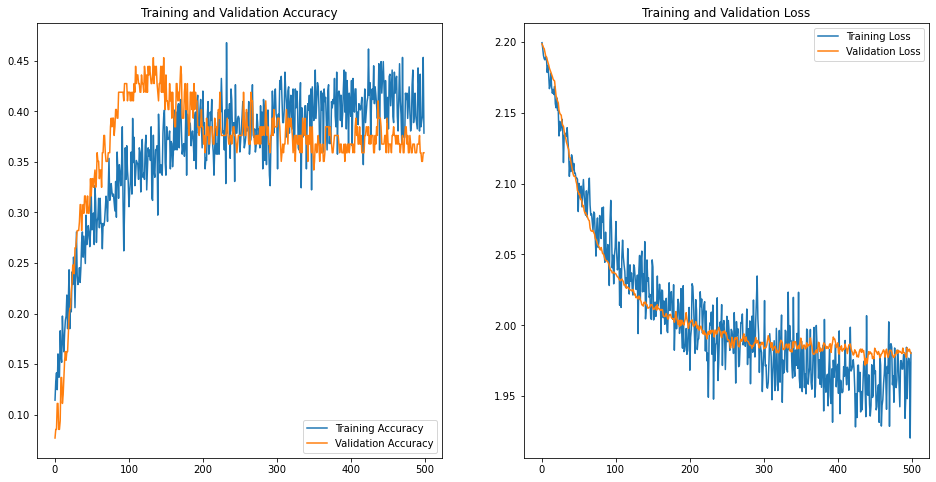

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

file_name = "graph.png"

plt.savefig(os.path.join(CHECKPOINT_DIR, file_name))

plt.show()

# Make some test predictions

In [22]:
TEST_DIR = "reduced_training_data/test"
TEST_CLASSES = ["707-320", "737-800", "777-200", "a330-200", "bae 146-300", "c-130", "eurofighter typhoon", "md-80", "spitfire"]

In [23]:
def plot_prediction(ax, prediction, actual, title):
    patches, texts, autotexts = ax.pie(prediction, labels=None, explode=[0.1] * len(prediction), autopct='%1.1f%%', shadow=True)
    
    ax.set_title(title)
#     ax.axis('equal')
    ax.legend(patches, TEST_CLASSES, bbox_to_anchor=(1.75, 0.5), loc="center right")
    

In [24]:
# This function will plot images in the form of a grid with 1 row and 3 columns.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [25]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=1,
                                                              directory=TEST_DIR,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="rgb",
                                                              class_mode='categorical')

Found 24 images belonging to 9 classes.


In [26]:
# plt.figure()
# test_images, _ = peek(test_data_gen)
# plotImages(test_images[:3])

In [27]:
predictions = model.predict(test_data_gen)
actual_classes = test_data_gen.classes

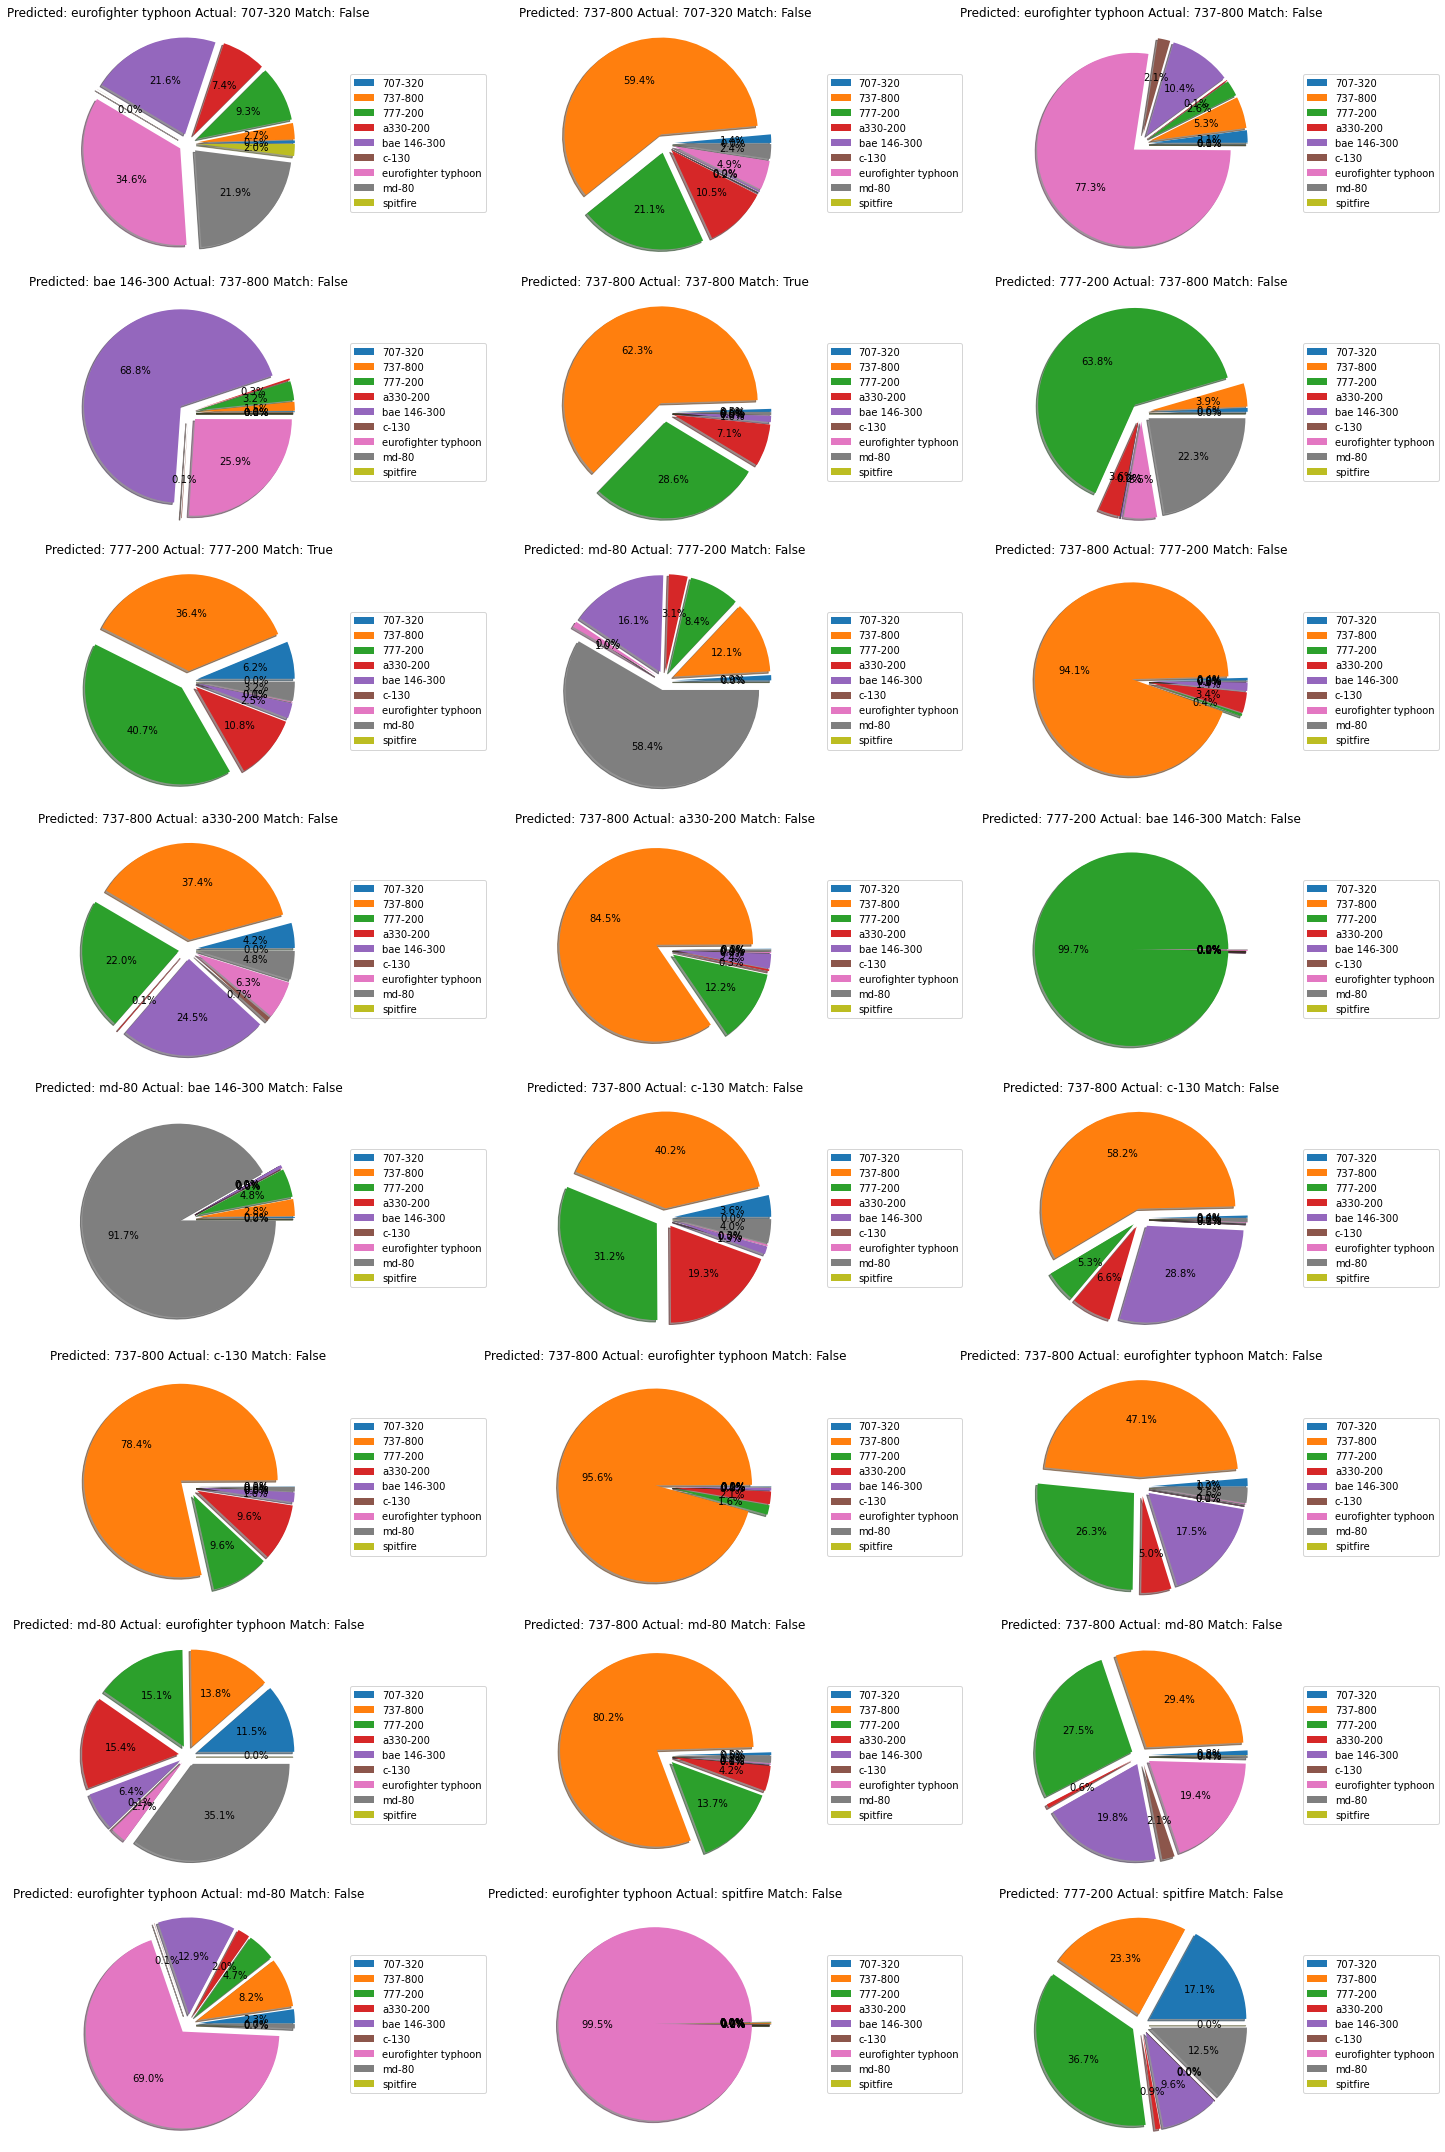

In [28]:
nrows = 3
ncol = 3

fig, ax = plt.subplots(math.ceil(len(predictions) / nrows), ncol, figsize=(20,30))

for index, predic in enumerate(predictions):
    predicted = np.argmax(predic)
    actual = actual_classes[index]
    title = "Predicted: {} Actual: {} Match: {}".format(TEST_CLASSES[predicted], TEST_CLASSES[actual], predicted==actual)
#     fig.figure(figsize=(6,24))
#     fig, ax = subplot(len(predictions), 1, index + 1)
    a = ax[int(index / nrows)][index % ncol]
    plot_prediction(a, predic, actual, title)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "test_results.pdf"), dpi=300, bbox_inches='tight')
plt.show()
